# Mixture of Compound Gaussians - MNIST experiments 

Compound Gaussian is a more general class of distributions that can be expressed as

$$X = \mu + \sqrt{\tau} A g$$

with $\tau \geq 0$ random variable, $g\sim \mathcal{N}(0, I)$, $AA^T=\Sigma$ 

$X_i|\tau=\tau_i \sim \mathcal{N}(\mu_j,\tau_i \Sigma_j)$

We load the libraries

In [49]:
import numpy as np
import random 
import pandas as pd
import os
import time
import csv 
import warnings

# MATH and STATS:
import math
from scipy.stats import t
from scipy.stats import multivariate_normal
from scipy.special import gamma

# PLOT:
import matplotlib.pyplot as plt
from plotnine import *
from plotnine.data import *
%matplotlib inline

# SKLEARN:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import spectral_clustering
from sklearn.manifold import TSNE
from sklearn import metrics # AMII and ARI
from sklearn import decomposition #PCA

# EMBEDDING:
import umap
import hdbscan

In [2]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [3]:
from frem import *
from import_subset_datasets import *

In [4]:
warnings.filterwarnings('ignore')

# MNIST 

### Import pairs [3, 8] and [7, 1]

In [6]:
np.random.seed(44)
random.seed(44)

read_mnist = pd.read_csv(r"data\mnist_train.csv")

mnist_labels_raw = read_mnist.iloc[:, 0]

mnist_data = read_mnist.iloc[:, 1:]

selected_digits = [3, 8]
selected_digits_2 = [7, 1]

mnist_pca, mnist_labels, mnist_raw, ve = import_subset(mnist_data, mnist_labels_raw, selected_digits,30, 800)
mnist_pca_2, mnist_labels_2, mnist_raw_2, ve2 = import_subset(mnist_data, mnist_labels_raw, selected_digits_2, 30, 800)

In [6]:
np.savetxt("mnist_pca.csv", mnist_pca, delimiter=",") # to run in R
np.savetxt("mnist_pca_2.csv", mnist_pca_2, delimiter=",") # to run in R

In [39]:
np.savetxt("mnist_labels.csv", mnist_labels, delimiter=",") # to run in R

### Plot digits

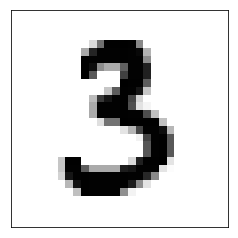

In [7]:
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,   
    left=False,
    labelleft=False,
    labelbottom=False)
plt.imshow((mnist_raw.iloc[0, :].values).reshape((28,28)), cmap="binary")

## Data 1: MNIST 3-8

### UMAP embedding

In [10]:
mnist_pca

embedding = umap.UMAP(
                      metric='euclidean').fit_transform(mnist_pca)

label = pd.Series(mnist_labels)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['label'] = label.astype(str)
gg = ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
gg.save("MNIST38_real.png",dpi =300)

### K-means

In [11]:
nrep = 100
kmeans_AMI = np.zeros((nrep, ))
kmeans_ARI = np.zeros((nrep, ))

for rep in range(nrep):

    kmeans = KMeans(n_clusters=2).fit(mnist_pca)
    kmeans_ARI[rep] = metrics.adjusted_rand_score(label, kmeans.labels_.astype(str))
    kmeans_AMI[rep] = metrics.adjusted_mutual_info_score(label, kmeans.labels_.astype(str))
    
print(np.median(kmeans_AMI))
print(np.median(kmeans_ARI))
print(np.min(kmeans_AMI))
print(np.min(kmeans_ARI))
print(np.max(kmeans_AMI))
print(np.max(kmeans_ARI))
print(np.std(kmeans_AMI))
print(np.std(kmeans_ARI))

#em['kmeans'] = pd.Series(kmeans.labels_.astype(str))
#em['label'] = pd.Series(mnist_labels)
#ggplot(em, aes(x='A',y='B',color='kmeans'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

0.22035537906072133
0.2884626071030122
0.21930842483600033
0.2871196442650191
0.22246015773510938
0.29115791848935374
0.00046068551116582756
0.0005906760739300037


In [22]:
em = pd.DataFrame(embedding, columns=['A','B']) 
em['kmeans'] = kmeans.labels_.astype(str)
gg = ggplot(aes(x='A', y='B', color='kmeans'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
gg.save("MNIST38_kmeans.png",dpi =300)

In [10]:
print('AMI: ', metrics.adjusted_mutual_info_score(label, kmeans.labels_.astype(str)))
print('ARI: ', metrics.adjusted_rand_score(label, kmeans.labels_.astype(str)))
print('ACU: ', acc(label.astype(int), kmeans.labels_.astype(int)))
#print(max([np.sum(kmeans.labels_==mnist_labels)/len(mnist_labels), np.sum(kmeans.labels_!=mnist_labels)/len(mnist_labels)]))

AMI:  0.22035537906072133
ARI:  0.2884626071030122
ACU:  0.76875


### GMM-EM

In [13]:
nrep = 100
gmm_AMI = np.zeros((nrep, ))
gmm_ARI = np.zeros((nrep, ))

for rep in range(nrep):

    gmm = GaussianMixture(n_components=2).fit(mnist_pca)
    labels_gmm = gmm.predict(mnist_pca)
    gmm_ARI[rep] = metrics.adjusted_rand_score(label, labels_gmm.astype(str))
    gmm_AMI[rep] = metrics.adjusted_mutual_info_score(label, labels_gmm.astype(str))
    
print(np.median(gmm_AMI))
print(np.median(gmm_ARI))
print(np.quantile(gmm_AMI, 0.25))
print(np.quantile(gmm_ARI, 0.25))
print(np.quantile(gmm_AMI, 0.75))
print(np.quantile(gmm_ARI, 0.75))
print(np.std(gmm_AMI))
print(np.std(gmm_ARI))  

#em['esti'] = pd.Series(labels_gmm.astype(str))
#ggplot(em, aes(x='A',y='B',color='esti'))+geom_point()+ylab("")+xlab("")

0.4878455512478535
0.5716519073226696
0.4878455512478535
0.5716519073226696
0.50368660382181
0.5888041321583289
0.010973335392483166
0.011877218821699936


In [14]:
em = pd.DataFrame(embedding, columns=['A','B']) 
em['gmm'] = labels_gmm.astype(str)
gg = ggplot(aes(x='A', y='B', color='gmm'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
gg.save("MNIST38_GMM.png",dpi =300)

In [15]:
print('ACU: ', acc(label.astype(int), labels_gmm.astype(int)))

ACU:  0.878125


In [34]:
print('AMI: ', metrics.adjusted_mutual_info_score(labels_gmm, mnist_labels))
print('ARI: ', metrics.adjusted_rand_score(labels_gmm, mnist_labels))
#print(max([np.sum(labels_gmm == mnist_labels)/len(mnist_labels), np.sum(labels_gmm !=mnist_labels)/len(mnist_labels)]))

AMI:  0.5116739170448108
ARI:  0.5984424245469742


### FREM

In [16]:
nrep = 1
frem_AMI = np.zeros((nrep, ))
frem_ARI = np.zeros((nrep, ))

for rep in range(nrep):
    theta_estimated_1, cond_prob_1, delta_mu_1, delta_sigma_1 = FREM(2, mnist_pca, 200, False, 2, 25)  
    labels_frem= np.array([i for i in np.argmax(cond_prob_1, axis=1)])

    frem_ARI[rep] = metrics.adjusted_rand_score(label, labels_frem.astype(str))
    frem_AMI[rep] = metrics.adjusted_mutual_info_score(label, labels_frem.astype(str))
    
print(np.median(frem_AMI))
print(np.median(frem_ARI))
print(np.quantile(frem_AMI, 0.25))
print(np.quantile(frem_ARI, 0.25))
print(np.quantile(frem_AMI, 0.75))
print(np.quantile(frem_ARI, 0.75))

ite:  0
ite:  10
ite:  20
ite:  30
ite:  40
ite:  50
ite:  60
convergence:  True
number of iterations:  68
0.5949424916598424
0.6887069859204329
0.5949424916598424
0.6887069859204329
0.5949424916598424
0.6887069859204329


In [17]:
em['frem'] = labels_frem.astype(str)
gg = ggplot(aes(x='A', y='B', color='frem'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
gg.save("MNIST38_frem.png",dpi =300)

In [15]:
print('ACU: ', acc(label.astype(int), labels_frem.astype(int)))

ACU:  0.915


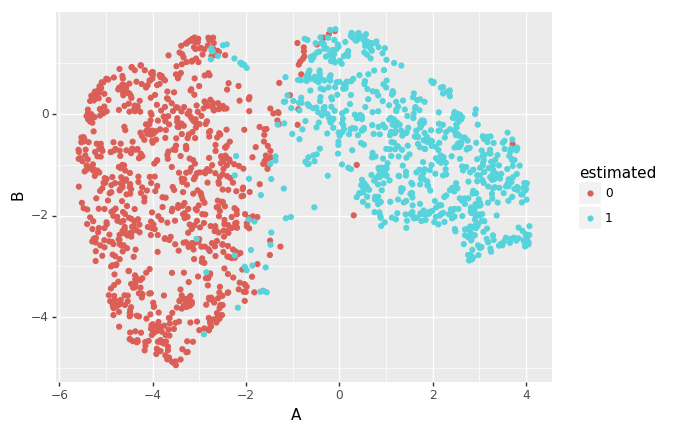

<ggplot: (-9223371889827756593)>

In [107]:
cond_prob = compute_condition_prob_matrix(mnist_pca, theta_estimated_1)
labels_cg = np.array([i for i in np.argmax(cond_prob, axis=1)])
em['estimated'] = pd.Series(labels_cg.astype(str))
ggplot(em, aes(x='A',y='B',color='estimated')) + geom_point()

In [108]:
print('AMI: ', metrics.adjusted_mutual_info_score(labels_cg, mnist_labels))
print('ARI: ', metrics.adjusted_rand_score(labels_cg, mnist_labels))
#print(max([np.sum(np.array(labels_cg) == mnist_labels)/len(mnist_labels), np.sum(np.array(labels_cg) !=mnist_labels)/len(mnist_labels)]))

AMI:  0.5949424916598425
ARI:  0.6887069859204329


### t-EM from R EMMIX

In [52]:
rlabels = pd.read_csv("labels_frem_MNIST.csv").values[:,0]

In [53]:
rlabels

array([2, 2, 2, ..., 1, 1, 1], dtype=int64)

In [47]:
em['tem'] = rlabels.astype(str)
gg = ggplot(aes(x='A', y='B', color='tem'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
gg.save("MNIST38_tem.png",dpi =300)

In [54]:
print('AMI: ', metrics.adjusted_mutual_info_score(mnist_labels, rlabels))
print('ARI: ', metrics.adjusted_rand_score(mnist_labels, rlabels))

AMI:  0.5701462942869372
ARI:  0.6701464744846766


In [55]:
print('ACU: ', acc(mnist_labels, rlabels))

ACU:  0.909375


### HDBSCAN

In [18]:
rrr = [5, 10, 15, 20, 25, 30, 35, 40 ,45, 50, 55, 60, 65, 70, 75, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500,  550, 600, 650, 700]
rrr2 = [1, 2, 3, 4,5, 10, 15, 20, 30, 40 ,50, 70, 80, 100]
maxim = 0
i_maxim = 0
ite = 0
for param1 in rrr:
    for param2 in rrr2:
        ite += 1
        print(ite)
        print(maxim, param1, param2)
        hdbis = hdbscan.HDBSCAN(min_cluster_size=param1, min_samples= param2)
        hdbis.fit(mnist_pca)
        em['hdbs'] = hdbis.labels_.astype(str)
        print("param1:", param1, "param2:", param2)
        print('AMI: ', metrics.adjusted_mutual_info_score(label, hdbis.labels_.astype(str)))
        print('ARI: ', metrics.adjusted_rand_score(label, hdbis.labels_.astype(str)))
        if (metrics.adjusted_mutual_info_score(label, hdbis.labels_.astype(str)) > maxim):
            i_maxim = ite
            maxim = metrics.adjusted_mutual_info_score(label, hdbis.labels_.astype(str))

        # print(ggplot(aes(x='A', y='B', color='hdbs'), data=em)+geom_point()+ scale_color_discrete(guide=False) +xlab("")+ylab(""))


1
0 5 1
param1: 5 param2: 1
AMI:  0.012277719047954433
ARI:  0.0033414852204937955
2
0.012277719047954433 5 2
param1: 5 param2: 2
AMI:  0.007667324455507437
ARI:  0.004771506891330604
3
0.012277719047954433 5 3
param1: 5 param2: 3
AMI:  0.010824696164088226
ARI:  0.005164380370071043
4
0.012277719047954433 5 4
param1: 5 param2: 4
AMI:  0.005641785985380818
ARI:  0.0015269549611890813
5
0.012277719047954433 5 5
param1: 5 param2: 5
AMI:  0.0054715894063049955
ARI:  -0.00032569519247969107
6
0.012277719047954433 5 10
param1: 5 param2: 10
AMI:  0.016483315391053334
ARI:  0.00026035019937747564
7
0.016483315391053334 5 15
param1: 5 param2: 15
AMI:  0.09432847145212264
ARI:  0.00937365747395663
8
0.09432847145212264 5 20
param1: 5 param2: 20
AMI:  0.008677801523399649
ARI:  0.00032924006158374614
9
0.09432847145212264 5 30
param1: 5 param2: 30
AMI:  0.03486468247494922
ARI:  0.0016994553840469111
10
0.09432847145212264 5 40
param1: 5 param2: 40
AMI:  0.03179899885541444
ARI:  0.0017694235934

ARI:  0.0
98
0.09432847145212264 35 100
param1: 35 param2: 100
AMI:  0.0
ARI:  0.0
99
0.09432847145212264 40 1
param1: 40 param2: 1
AMI:  0.04922806202151717
ARI:  0.005517569033831747
100
0.09432847145212264 40 2
param1: 40 param2: 2
AMI:  0.03611623793375153
ARI:  0.002682788051728919
101
0.09432847145212264 40 3
param1: 40 param2: 3
AMI:  0.0
ARI:  0.0
102
0.09432847145212264 40 4
param1: 40 param2: 4
AMI:  0.0
ARI:  0.0
103
0.09432847145212264 40 5
param1: 40 param2: 5
AMI:  0.0
ARI:  0.0
104
0.09432847145212264 40 10
param1: 40 param2: 10
AMI:  0.0
ARI:  0.0
105
0.09432847145212264 40 15
param1: 40 param2: 15
AMI:  0.09432847145212264
ARI:  0.00937365747395663
106
0.09432847145212264 40 20
param1: 40 param2: 20
AMI:  0.0
ARI:  0.0
107
0.09432847145212264 40 30
param1: 40 param2: 30
AMI:  0.0
ARI:  0.0
108
0.09432847145212264 40 40
param1: 40 param2: 40
AMI:  0.0
ARI:  0.0
109
0.09432847145212264 40 50
param1: 40 param2: 50
AMI:  0.0
ARI:  0.0
110
0.09432847145212264 40 70
param1: 

ARI:  0.0
209
0.09432847145212264 75 80
param1: 75 param2: 80
AMI:  0.0
ARI:  0.0
210
0.09432847145212264 75 100
param1: 75 param2: 100
AMI:  0.0
ARI:  0.0
211
0.09432847145212264 80 1
param1: 80 param2: 1
AMI:  0.0
ARI:  0.0
212
0.09432847145212264 80 2
param1: 80 param2: 2
AMI:  0.0
ARI:  0.0
213
0.09432847145212264 80 3
param1: 80 param2: 3
AMI:  0.0
ARI:  0.0
214
0.09432847145212264 80 4
param1: 80 param2: 4
AMI:  0.0
ARI:  0.0
215
0.09432847145212264 80 5
param1: 80 param2: 5
AMI:  0.0
ARI:  0.0
216
0.09432847145212264 80 10
param1: 80 param2: 10
AMI:  0.0
ARI:  0.0
217
0.09432847145212264 80 15
param1: 80 param2: 15
AMI:  0.0
ARI:  0.0
218
0.09432847145212264 80 20
param1: 80 param2: 20
AMI:  0.0
ARI:  0.0
219
0.09432847145212264 80 30
param1: 80 param2: 30
AMI:  0.0
ARI:  0.0
220
0.09432847145212264 80 40
param1: 80 param2: 40
AMI:  0.0
ARI:  0.0
221
0.09432847145212264 80 50
param1: 80 param2: 50
AMI:  0.0
ARI:  0.0
222
0.09432847145212264 80 70
param1: 80 param2: 70
AMI:  0.0


AMI:  0.0
ARI:  0.0
322
0.09432847145212264 400 100
param1: 400 param2: 100
AMI:  0.0
ARI:  0.0
323
0.09432847145212264 450 1
param1: 450 param2: 1
AMI:  0.0
ARI:  0.0
324
0.09432847145212264 450 2
param1: 450 param2: 2
AMI:  0.0
ARI:  0.0
325
0.09432847145212264 450 3
param1: 450 param2: 3
AMI:  0.0
ARI:  0.0
326
0.09432847145212264 450 4
param1: 450 param2: 4
AMI:  0.0
ARI:  0.0
327
0.09432847145212264 450 5
param1: 450 param2: 5
AMI:  0.0
ARI:  0.0
328
0.09432847145212264 450 10
param1: 450 param2: 10
AMI:  0.0
ARI:  0.0
329
0.09432847145212264 450 15
param1: 450 param2: 15
AMI:  0.0
ARI:  0.0
330
0.09432847145212264 450 20
param1: 450 param2: 20
AMI:  0.0
ARI:  0.0
331
0.09432847145212264 450 30
param1: 450 param2: 30
AMI:  0.0
ARI:  0.0
332
0.09432847145212264 450 40
param1: 450 param2: 40
AMI:  0.0
ARI:  0.0
333
0.09432847145212264 450 50
param1: 450 param2: 50
AMI:  0.0
ARI:  0.0
334
0.09432847145212264 450 70
param1: 450 param2: 70
AMI:  0.0
ARI:  0.0
335
0.09432847145212264 45

In [19]:
i_maxim

7

In [32]:
from mizani.palettes import (hue_pal, brewer_pal, grey_pal,
                             gradient_n_pal, cmap_pal, cmap_d_pal,
                             desaturate_pal)
hue_pal(h=.01, l=.6, s=.65, color_space='hls')(2)

['#db5f57', '#57d3db']

In [33]:
hdbis = hdbscan.HDBSCAN(min_cluster_size=5, min_samples = 15)
hdbis.fit(mnist_pca)
em['hdbs'] = hdbis.labels_.astype(str)
print("param1:", param1, "param2:", param2)
print(hdbis.labels_)
print('AMI: ', metrics.adjusted_mutual_info_score(label, hdbis.labels_.astype(str)))
print('ARI: ', metrics.adjusted_rand_score(label, hdbis.labels_.astype(str)))
if (metrics.adjusted_mutual_info_score(label, hdbis.labels_.astype(str)) > maxim):
    i_maxim = ite
    maxim = metrics.adjusted_mutual_info_score(label, hdbis.labels_.astype(str))

gg = ggplot(aes(x='A', y='B', color='hdbs'), data=em)+geom_point()+scale_color_manual(["black","#db5f57", "#57d3db"], guide = False) + xlab("")+ylab("")
gg.save("MNIST38_hdbscan.png",dpi =300)

param1: 700 param2: 100
[ 0 -1  0 ... -1 -1 -1]
AMI:  0.09432847145212264
ARI:  0.00937365747395663


In [15]:
i_maxim

7

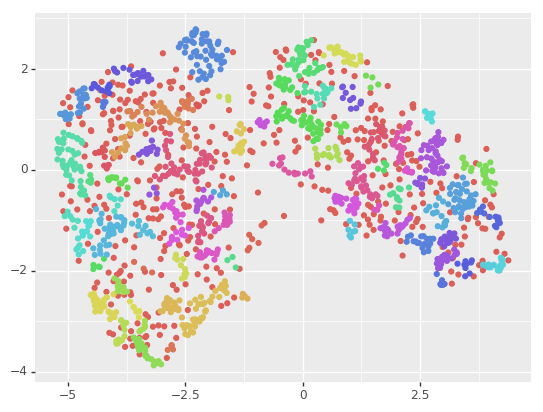

<ggplot: (146970363119)>


In [33]:
hdbis = hdbscan.HDBSCAN(min_cluster_size=3, min_samples= 3)
hdbis.fit(embedding)
em['hdbs'] = hdbis.labels_.astype(str)
print(ggplot(aes(x='A', y='B', color='hdbs'), data=em)+geom_point()+ scale_color_discrete(guide=False) +xlab("")+ylab(""))

In [11]:
print('AMI: ', metrics.adjusted_mutual_info_score(label,hdbis.labels_.astype(str)))
print('ARI: ', metrics.adjusted_rand_score(label, hdbis.labels_.astype(str)))

AMI:  0.5114197057666036
ARI:  0.6866862254417434


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


### Spectral

In [35]:
spectral = SpectralClustering(n_clusters = 2, affinity= "nearest_neighbors", n_neighbors=5)
spectral.fit(mnist_pca)
print(spectral.labels_)
print('AMI: ', metrics.adjusted_mutual_info_score(label, spectral.labels_.astype(str)))
print('ARI: ', metrics.adjusted_rand_score(label, spectral.labels_.astype(str)))

[1 1 1 ... 0 0 0]
AMI:  0.5839478466457573
ARI:  0.6558896386002074


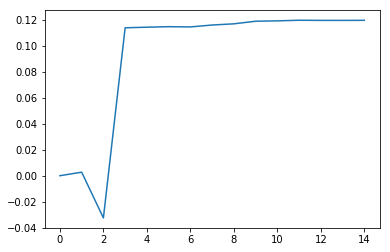

In [184]:
plt.plot(silu)
plt.show()

In [48]:
em['spectral'] = spectral.labels_.astype(str)
gg = ggplot(aes(x='A', y='B', color='spectral'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
gg.save("MNIST38_spectral.png",dpi =300)

In [56]:
print('ACU: ', acc(mnist_labels, spectral.labels_.astype(int)))

ACU:  0.905


## Data 2: MNIST 7-1

### UMAP

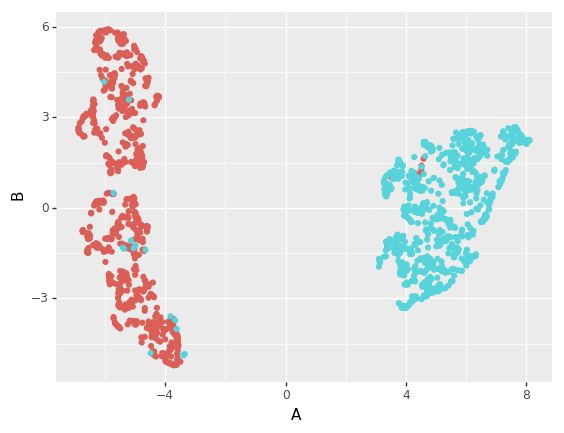

<ggplot: (115971792150)>

In [60]:
embedding2 = umap.UMAP(n_neighbors=10, min_dist=0.001,
                      metric='euclidean').fit_transform(mnist_pca_2)

label = pd.Series(mnist_labels_2)
em2 = pd.DataFrame(embedding2, columns=['A','B']) 
em2['label'] = label.astype(str)
ggplot(aes(x='A', y='B', color='label'), data=em2)+geom_point()+ scale_color_discrete(guide=False)

### Kmeans

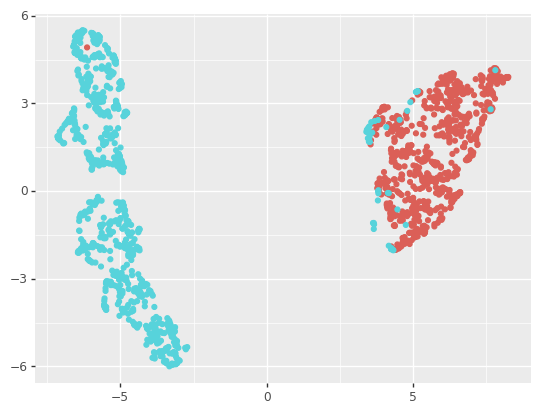

<ggplot: (115971648502)>

In [58]:
kmeans = KMeans(n_clusters=2).fit(mnist_pca_2)
em2['kmeans'] = pd.Series(kmeans.labels_.astype(str))
em2['label'] = pd.Series(mnist_labels_2)
ggplot(em2, aes(x='A',y='B',color='kmeans'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

In [59]:
print('AMI: ', metrics.adjusted_mutual_info_score(mnist_labels_2, kmeans.labels_.astype(str)))
print('ARI: ', metrics.adjusted_rand_score(mnist_labels_2, kmeans.labels_.astype(str)))
print('ACC: ', acc(mnist_labels_2.astype(int), kmeans.labels_.astype(int)))

AMI:  0.783900649843642
ARI:  0.848607330415779
ACC:  0.960625


### GMM

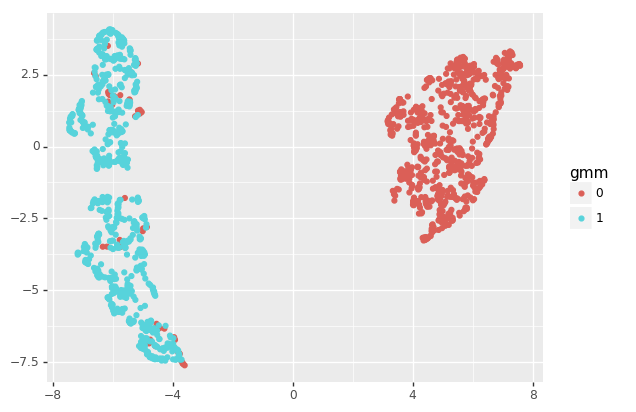

<ggplot: (135566711486)>

In [13]:
gmm = GaussianMixture(n_components=2).fit(mnist_pca_2)
labels_gmm_2 = gmm.predict(mnist_pca_2)
em2['gmm'] = pd.Series(labels_gmm_2.astype(str))
ggplot(em2, aes(x='A',y='B',color='gmm'))+geom_point()+ylab("")+xlab("")

In [24]:
print('AMI: ', metrics.adjusted_mutual_info_score(mnist_labels_2, labels_gmm_2))
print('ARI: ', metrics.adjusted_rand_score(mnist_labels_2, labels_gmm_2))
print('ACC: ', acc(mnist_labels_2.astype(int), labels_gmm_2.astype(int)))

AMI:  0.8414571906639253
ARI:  0.8905958586351946
ACC:  0.971875


### Robust EM

In [20]:
nrep = 1
frem_AMI_2 = np.zeros((nrep, ))
frem_ARI_2 = np.zeros((nrep, ))

for rep in range(nrep):
    theta_estimated_1, cond_prob_1, delta_mu_1, delta_sigma_1 = FREM(2, mnist_pca_2, 150, False, 4, 30) 
    labels_frem= np.array([i for i in np.argmax(cond_prob_1, axis=1)])

    frem_ARI_2[rep] = metrics.adjusted_rand_score(label, labels_frem.astype(str))
    frem_AMI_2[rep] = metrics.adjusted_mutual_info_score(label, labels_frem.astype(str))


ite:  10
ite:  20
convergence:  True
number of iterations:  29


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [21]:
print(np.median(frem_AMI_2))
print(np.median(frem_ARI_2))
print(np.quantile(frem_AMI_2, 0.25))
print(np.quantile(frem_ARI_2, 0.25))
print(np.quantile(frem_AMI_2, 0.75))
print(np.quantile(frem_ARI_2, 0.75))
print('ACU: ', acc(mnist_labels_2.astype(int), labels_frem.astype(int)))
labels_gmm_2

0.8991131003559472
0.9481566401867992
0.8991131003559472
0.9481566401867992
0.8991131003559472
0.9481566401867992
ACU:  0.986875


array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

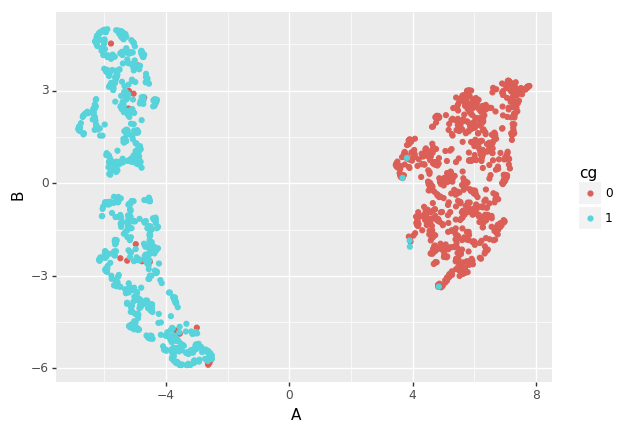

<ggplot: (-9223371889828695138)>

In [126]:
cond_prob_2 = compute_condition_prob_matrix(mnist_pca_2, theta_estimated_1)
labels_cg_2 = np.array([i for i in np.argmax(cond_prob_2, axis=1)])
em2['cg'] = pd.Series(labels_cg_2.astype(str))
ggplot(em2, aes(x='A',y='B',color='cg'))+geom_point()

In [127]:
print('AMI: ', metrics.adjusted_mutual_info_score( mnist_labels_2, labels_cg_2))
print('ARI: ', metrics.adjusted_rand_score(mnist_labels_2, labels_cg_2))

AMI:  0.8811877642402497
ARI:  0.9360162391416621


### t-EM from R

In [64]:
rlabels = pd.read_csv("labels_frem_MNIST_2.csv").values[:,0]
print('AMI: ', metrics.adjusted_mutual_info_score(mnist_labels_2, rlabels))
print('ARI: ', metrics.adjusted_rand_score(mnist_labels_2, rlabels))
print('ACU: ', acc(mnist_labels_2.astype(int), rlabels))

AMI:  0.8947586210105201
ARI:  0.9432911066409212
ACU:  0.985625


### spectral

In [62]:
spectral = SpectralClustering(n_clusters = 2, affinity= "nearest_neighbors", n_neighbors=5)
spectral.fit(mnist_pca_2)
print('AMI: ', metrics.adjusted_mutual_info_score(label, spectral.labels_.astype(str)))
print('ARI: ', metrics.adjusted_rand_score(label, spectral.labels_.astype(str)))
print('ACU: ', acc(mnist_labels_2.astype(int), spectral.labels_.astype(int)))

AMI:  0.8852590746329808
ARI:  0.93843806710196
ACU:  0.984375


## MNIST -  [3, 8, 6]

In [101]:
np.random.seed(44)
random.seed(44)

selected_digits_3 = [3, 8, 6]

mnist_pca_3, mnist_labels_3, mnist_raw_3, ve3 = import_subset(mnist_data, mnist_labels_raw, selected_digits_3, 30, 700)

In [102]:
np.savetxt("mnist_pca_3.csv", mnist_pca_3, delimiter=",") # to run in R

### Plot digits

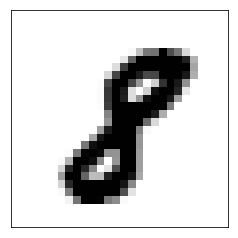

In [103]:
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,   
    left=False,
    labelleft=False,
    labelbottom=False)
plt.imshow((mnist_raw_3.iloc[1200, :].values).reshape((28,28)), cmap="binary")

### UMAP embedding

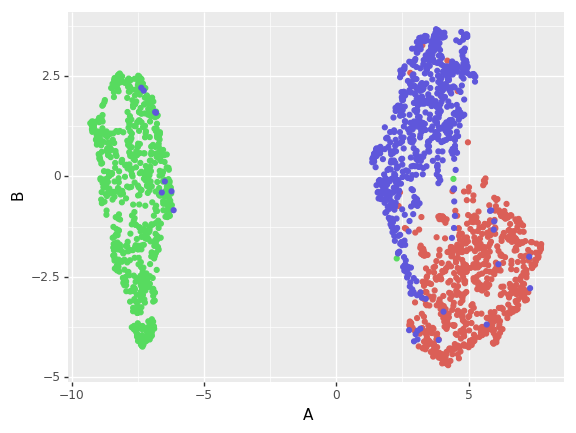

<ggplot: (115967697521)>

In [104]:
mnist_pca

embedding = umap.UMAP(n_neighbors=10,
                      metric='euclidean').fit_transform(mnist_pca_3)

label = pd.Series(mnist_labels_3)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['label'] = label.astype(str)
ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)

### UMAP embedding + HDBSCAN

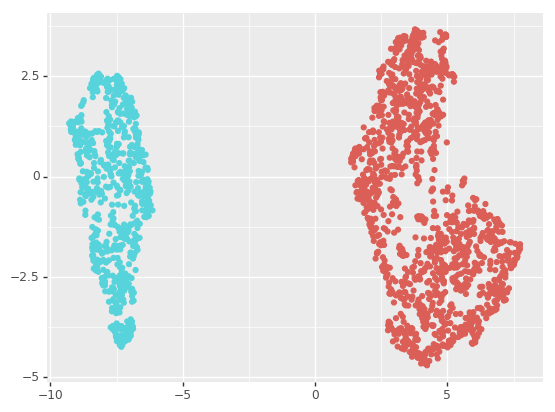

<ggplot: (-9223371919950707354)>

In [251]:
import hdbscan

hdbis = hdbscan.HDBSCAN(min_cluster_size=60, min_samples = 10)
hdbis.fit(embedding)
hdbis.labels_
np.unique(hdbis.labels_)
em['hdbs'] = hdbis.labels_.astype(str)
ggplot(aes(x='A', y='B', color='hdbs'), data=em)+geom_point()+ scale_color_discrete(guide=False) +xlab("")+ylab("")

### K-means

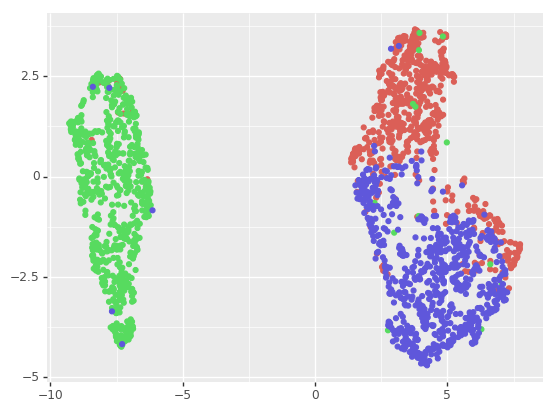

<ggplot: (115967628815)>

In [105]:
kmeans = KMeans(n_clusters=3).fit(mnist_pca_3)
em['kmeans'] = pd.Series(kmeans.labels_.astype(str))
ggplot(em, aes(x='A',y='B',color='kmeans'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

In [107]:
print('AMI: ', metrics.adjusted_mutual_info_score(label, kmeans.labels_.astype(str)))
print('ARI: ', metrics.adjusted_rand_score(label, kmeans.labels_.astype(str)))
print('ACU: ', acc(label,  kmeans.labels_.astype(int)))

AMI:  0.6149216366387751
ARI:  0.6338861547158647
ACU:  0.8495238095238096


### GMM-EM

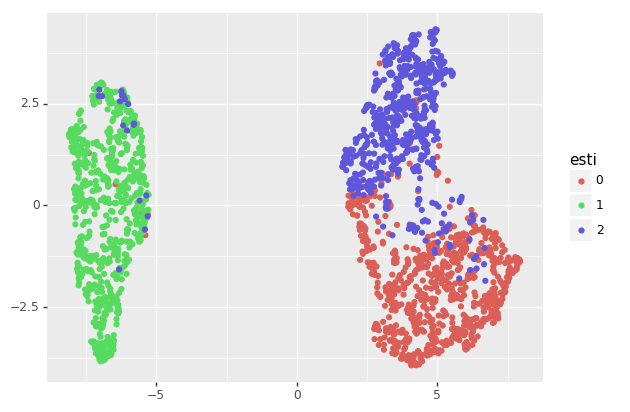

<ggplot: (-9223371920887249464)>

In [80]:
gmm = GaussianMixture(n_components=3).fit(mnist_pca_3)
labels_gmm = gmm.predict(mnist_pca_3)
em['esti'] = pd.Series(labels_gmm.astype(str))
ggplot(em, aes(x='A',y='B',color='esti'))+geom_point()+ylab("")+xlab("")

In [81]:
print('AMI: ', metrics.adjusted_mutual_info_score(label, labels_gmm))
print('ARI: ', metrics.adjusted_rand_score(label, labels_gmm))

AMI:  0.7159888628807809
ARI:  0.7332622355314284


In [82]:
print('ACU: ', acc(label, labels_gmm.astype(int)))

ACU:  0.8976190476190476


### FREM

In [91]:
nrep = 1
frem_AMI_3 = np.zeros((nrep, ))
frem_ARI_3 = np.zeros((nrep, ))

for rep in range(nrep):
    theta_estimated_1, cond_prob_1, delta_mu_1, delta_sigma_1 = FREM(3, mnist_pca_3, 250, False, 1, 20)  
    labels_frem= np.array([i for i in np.argmax(cond_prob_1, axis=1)])

    frem_ARI_3[rep] = metrics.adjusted_rand_score(label, labels_frem.astype(str))
    frem_AMI_3[rep] = metrics.adjusted_mutual_info_score(label, labels_frem.astype(str))
    
print(np.median(frem_AMI_3))
print(np.median(frem_ARI_3))
print(np.quantile(frem_AMI_3, 0.25))
print(np.quantile(frem_ARI_3, 0.25))
print(np.quantile(frem_AMI_3, 0.75))
print(np.quantile(frem_ARI_3, 0.75))

ite:  0
ite:  10
ite:  20
ite:  30
ite:  40
ite:  50
ite:  60
ite:  70
ite:  80
convergence:  True
number of iterations:  90
0.7918707371621785
0.8306280282838749
0.7918707371621785
0.8306280282838749
0.7918707371621785
0.8306280282838749


In [92]:
print('ACU: ', acc(label, labels_frem.astype(int)))

ACU:  0.939047619047619


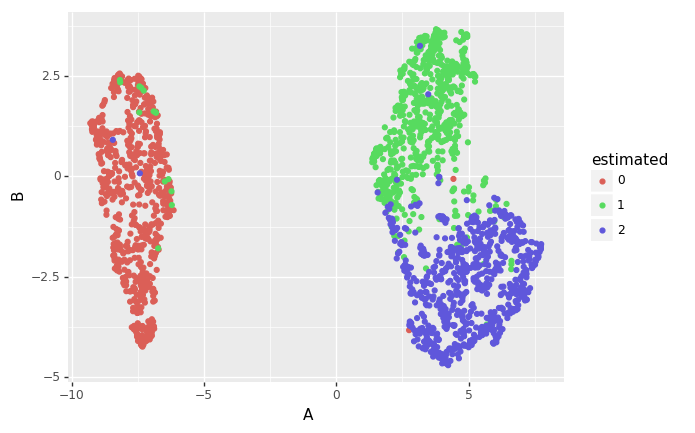

<ggplot: (146973070077)>

In [140]:
cond_prob = compute_condition_prob_matrix(mnist_pca_3, theta_estimated_1)
labels_cg_3 = np.array([i for i in np.argmax(cond_prob, axis=1)])
em['estimated'] = pd.Series(labels_cg_3.astype(str))
ggplot(em, aes(x='A',y='B',color='estimated'))+geom_point()

In [141]:
print('AMI: ', metrics.adjusted_mutual_info_score(label, labels_cg_3))
print('ARI: ', metrics.adjusted_rand_score(label, labels_cg_3))

AMI:  0.7918707371621786
ARI:  0.8306280282838749


### Spectral

In [70]:
spectral = SpectralClustering(n_clusters = 3, affinity= "nearest_neighbors", n_neighbors=5)
spectral.fit(mnist_pca_3)
print(spectral.labels_)
print('AMI: ', metrics.adjusted_mutual_info_score(label, spectral.labels_.astype(str)))
print('AMI: ', metrics.adjusted_rand_score(label, spectral.labels_.astype(str)))
print('ACU: ', acc(label, spectral.labels_.astype(int)))

[2 2 2 ... 0 0 0]
AMI:  0.8272704069764195
AMI:  0.8542643605488299
ACU:  0.9476190476190476


### t-EM

In [111]:
rlabels = pd.read_csv("labels_frem_MNIST_3.csv").values[:,0]
print('AMI: ', metrics.adjusted_mutual_info_score(label, rlabels))
print('ARI: ', metrics.adjusted_rand_score(label, rlabels))
print('ACU: ', acc(mnist_labels_3, rlabels))

AMI:  0.782516388645691
ARI:  0.8238245755150039
ACU:  0.9366666666666666


## Introducing some noise

In [112]:
np.random.seed(999)
random.seed(999)

selected_digits_5 = [3, 8, 6]

mnist_pca_5, mnist_labels_5, mnist_raw_5, ve5 = import_subset(mnist_data, mnist_labels_raw, selected_digits_5, 30, 600) 

selected_digits_noise = [0,1,2,4,5,7,9]

mnist_pca_noise, mnist_labels_noise, mnist_raw_noise, ve_noise = import_subset(mnist_data, mnist_labels_raw, selected_digits_noise, 30, 40)
    
mnist_pca_5 = pd.concat((pd.DataFrame(mnist_pca_5), pd.DataFrame(mnist_pca_noise))).values
mnist_labels_5 = np.concatenate((mnist_labels_5, mnist_labels_noise))

In [113]:
np.savetxt("mnist_pca_5.csv", mnist_pca_5, delimiter=",") # to run in R

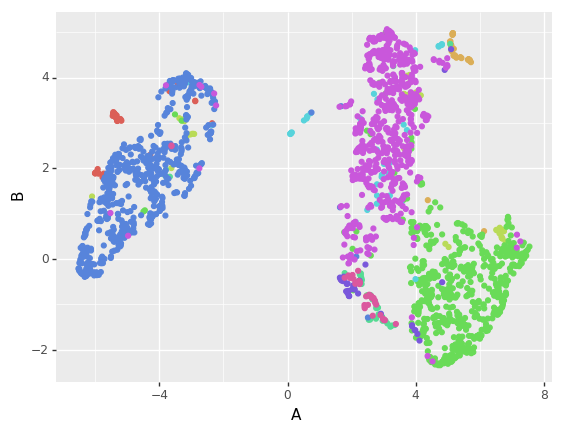

<ggplot: (-9223371920887036700)>

In [114]:
embedding = umap.UMAP(n_neighbors=10, min_dist=0.001,
                      metric='euclidean').fit_transform(mnist_pca_5)

label = pd.Series(mnist_labels_5)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['label'] = label.astype(str)
ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)

In [125]:
mnist_5_not_noise = np.isin(mnist_labels_5.astype(int), [3, 8, 6])

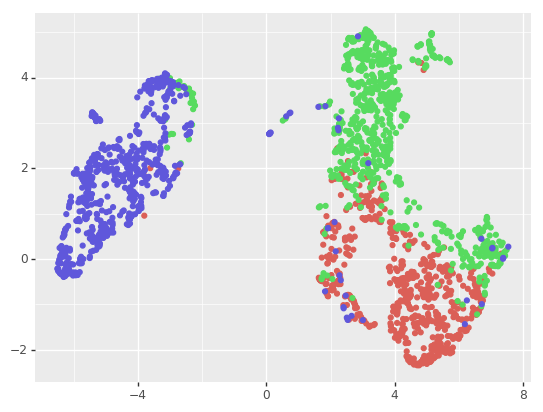

<ggplot: (115971872667)>

In [126]:
kmeans = KMeans(n_clusters=3).fit(mnist_pca_5)
em['kmeans'] = pd.Series(kmeans.labels_.astype(str))
ggplot(em, aes(x='A',y='B',color='kmeans'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

In [128]:
print('AMI: ', metrics.adjusted_mutual_info_score(label, kmeans.labels_))
print('ARI: ', metrics.adjusted_rand_score(label, kmeans.labels_))
print('ACU: ', acc(mnist_labels_5[mnist_5_not_noise],  kmeans.labels_[mnist_5_not_noise]))

AMI:  0.36225634790895306
ARI:  0.4475127012209064
ACU:  0.8144444444444444


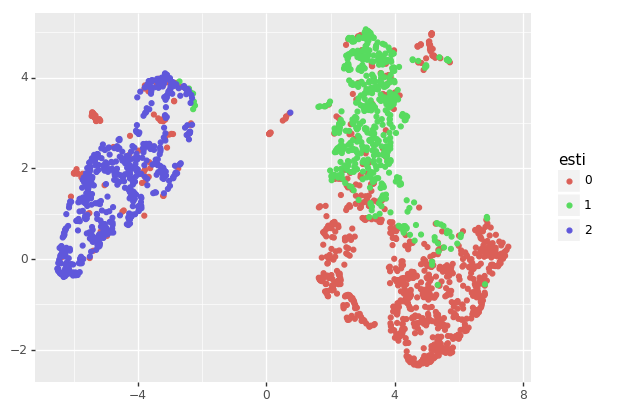

<ggplot: (115971900238)>

In [129]:
gmm = GaussianMixture(n_components=3).fit(mnist_pca_5)
labels_gmm = gmm.predict(mnist_pca_5)
em['esti'] = pd.Series(labels_gmm.astype(str))
ggplot(em, aes(x='A',y='B',color='esti'))+geom_point()+ylab("")+xlab("")

In [130]:
print('AMI: ', metrics.adjusted_mutual_info_score(label, labels_gmm))
print('ARI: ', metrics.adjusted_rand_score(label, labels_gmm))
print('ACU: ', acc(mnist_labels_5[mnist_5_not_noise],  labels_gmm[mnist_5_not_noise]))

AMI:  0.4418199408588174
ARI:  0.49092176905869955
ACU:  0.87


In [131]:
nrep = 1
frem_AMI_5 = np.zeros((nrep, ))
frem_ARI_5 = np.zeros((nrep, ))

for rep in range(nrep):
    theta_estimated_1, cond_prob_1, delta_mu_1, delta_sigma_1 = FREM(3, mnist_pca_5, 150, False, 1, 20)  
    labels_frem= np.array([i for i in np.argmax(cond_prob_1, axis=1)])

    frem_ARI_5[rep] = metrics.adjusted_rand_score(label, labels_frem.astype(str))
    frem_AMI_5[rep] = metrics.adjusted_mutual_info_score(label, labels_frem.astype(str))
    
print(np.median(frem_AMI_5))
print(np.median(frem_ARI_5))
print(np.quantile(frem_AMI_5, 0.25))
print(np.quantile(frem_ARI_5, 0.25))
print(np.quantile(frem_AMI_5, 0.75))
print(np.quantile(frem_ARI_5, 0.75))

ite:  0
ite:  10
ite:  20
ite:  30
ite:  40
ite:  50
ite:  60
ite:  70
ite:  80
convergence:  True
number of iterations:  87
0.466484830147149
0.5548688329264354
0.466484830147149
0.5548688329264354
0.466484830147149
0.5548688329264354


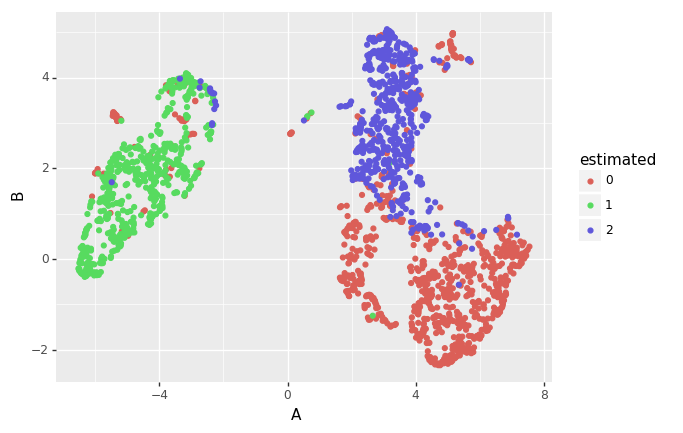

<ggplot: (146973427071)>

In [154]:
cond_prob = compute_condition_prob_matrix(mnist_pca_5, theta_estimated_1)
labels_cg = np.array([i for i in np.argmax(cond_prob, axis=1)])
em['estimated'] = pd.Series(labels_cg.astype(str))
ggplot(em, aes(x='A',y='B',color='estimated'))+geom_point()

In [133]:
print('AMI: ', metrics.adjusted_mutual_info_score(label, labels_frem))
print('ARI: ', metrics.adjusted_rand_score(label, labels_frem))
print('ACU: ', acc(mnist_labels_5[mnist_5_not_noise],  labels_frem[mnist_5_not_noise]))

AMI:  0.466484830147149
ARI:  0.5548688329264354
ACU:  0.8966666666666666


In [134]:
rlabels = pd.read_csv("labels_frem_MNIST_5.csv").values[:,0]
print('AMI: ', metrics.adjusted_mutual_info_score(label, rlabels))
print('ARI: ', metrics.adjusted_rand_score(label, rlabels))
print('ACU: ', acc(mnist_labels_5[mnist_5_not_noise],  rlabels[mnist_5_not_noise]))

AMI:  0.4621129528771764
ARI:  0.531337948160797
ACU:  0.8894444444444445


In [136]:
spectral = SpectralClustering(n_clusters = 3, affinity= "nearest_neighbors", n_neighbors=6)
spectral.fit(mnist_pca_5)
print('AMI: ', metrics.adjusted_mutual_info_score(mnist_labels_5, spectral.labels_.astype(str)))
print('AMI: ', metrics.adjusted_rand_score(mnist_labels_5, spectral.labels_.astype(str)))
print('ACU: ', acc(mnist_labels_5[mnist_5_not_noise],  spectral.labels_[mnist_5_not_noise]))

AMI:  0.35115694557816013
AMI:  0.31155029712112364
ACU:  0.5444444444444444
